In [ ]:
import torch
from torch.utils.data import DataLoader, random_split, Subset
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
import random
import numpy as np
import os
import matplotlib.pyplot as plt
import copy
import pickle


In [71]:
def fix_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Fixed random seed: {seed}")

fix_random_seed(42)

# For deterministic DataLoader behavior
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

Fixed random seed: 42


In [72]:

# ==========================================================
# Configuration
# ==========================================================
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
BATCH_SIZE = 128
NUM_WORKERS = 4

g = torch.Generator()
g.manual_seed(42)

# ==========================================================
# Transforms
# ==========================================================
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

# ==========================================================
# Datasets and Splits
# ==========================================================
# Load once (without transform)
full_train = torchvision.datasets.CIFAR100(root='./data', train=True, download=True)
full_test = torchvision.datasets.CIFAR100(root='./data', train=False, download=True)

# Split indices using a fixed seed generator
train_indices, val_indices = random_split(range(len(full_train)), [45000, 5000], generator=g)
test_indices, small_test_indices = random_split(range(len(full_test)), [7500, 2500], generator=g)

# Wrap each subset with its own dataset and transform
train_dataset = Subset(
    torchvision.datasets.CIFAR100(root='./data', train=True, transform=train_transform),
    train_indices.indices
)
val_dataset = Subset(
    torchvision.datasets.CIFAR100(root='./data', train=True, transform=test_transform),
    val_indices.indices
)
test_dataset = Subset(
    torchvision.datasets.CIFAR100(root='./data', train=False, transform=test_transform),
    test_indices.indices
)
small_test_dataset = Subset(
    torchvision.datasets.CIFAR100(root='./data', train=False, transform=test_transform),
    small_test_indices.indices
)

print("Training set size:", len(train_dataset))
print("Validation set size:", len(val_dataset))
print("Test set size:", len(test_dataset))
print("Small test size:", len(small_test_dataset))

# ==========================================================
# Dataloaders
# ==========================================================
def get_loader(dataset, shuffle):
    return DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
        num_workers=NUM_WORKERS,
        pin_memory=True,
        worker_init_fn=seed_worker,
        generator=g
    )

train_loader = get_loader(train_dataset, shuffle=True)
val_loader = get_loader(val_dataset, shuffle=False)
test_loader = get_loader(test_dataset, shuffle=False)
small_test_loader = get_loader(small_test_dataset, shuffle=False)


Training set size: 45000
Validation set size: 5000
Test set size: 7500
Small test size: 2500


In [73]:
def plot_weight_histograms(model, title):
    # Collect (layer_name, weights) pairs
    layer_weights = []
    for name, module in model.named_modules():
        if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
            layer_weights.append((name, module.weight.detach().cpu().numpy().flatten()))

    # Plot histograms
    plt.figure(figsize=(15, 8))
    for i, (name, w) in enumerate(layer_weights[:11]):  # limit to first 11 for readability
        plt.subplot(5, 6, i + 1)
        plt.hist(w, bins=40, color='blue', alpha=0.7)
        plt.title(name, fontsize=9)  # <-- actual layer name
        plt.tight_layout()
    plt.suptitle(title, y=1.02)
    plt.show()

In [74]:
vgg11 = models.vgg11(weights=models.VGG11_Weights.IMAGENET1K_V1)
vgg11.classifier[6] = torch.nn.Linear(4096, 100)
vgg11.classifier[5] = torch.nn.Dropout(p=0.5) # Dropout
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"
vgg11.load_state_dict(torch.load('models/vgg11_cifar100_baseline.pt', weights_only=True, map_location=device))
vgg11.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [75]:
with open('models/sensitivity_dict_structured.pkl', 'rb') as f:
    sensitivity_dict = pickle.load(f)

In [76]:
def evaluate(model, test_loader, device):
    model.to(device)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            preds = model(images)
            preds = torch.argmax(preds, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total * 100
    return accuracy

In [77]:
base_acc = evaluate(vgg11, test_loader, device)
print(f"Base Acc: {base_acc:.2f}%")

base_acc = evaluate(vgg11, small_test_loader, device)
print(f"Base Acc (small): {base_acc:.2f}%")

Base Acc: 74.33%
Base Acc (small): 73.28%


In [78]:
prune_amts = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
conv_layers = [name for name, module in vgg11.named_modules() if isinstance(module, torch.nn.Conv2d)]

desired_channel_prune = 0.3   # 30% of total conv output channels
min_layer_prune = 0.05        # don't prune less than 5%
max_layer_prune = 0.9         # cap per layer pruning


# 1) Gather Conv2d layers and their output channels
conv_out_channels = {}
conv_order = []
for name, module in vgg11.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        conv_out_channels[name] = module.out_channels
        conv_order.append(name)

conv_layers = conv_order[:-1]
total_channels = sum(conv_out_channels[name] for name in conv_layers)
total_channels_to_prune = int(desired_channel_prune * total_channels)

R = {}
for name in conv_layers:
    accs = []
    for p in prune_amts:
        acc = sensitivity_dict.get((name, p))
        if acc is not None:
            accs.append(acc)
    if not accs or base_acc == 0:
        R[name] = 1.0
    else:
        R[name] = (sum(accs) / len(accs)) / base_acc

# 3) Convert to sensitivity (S = 1 / R)
S = {n: 1.0 / max(R[n], 1e-6) for n in R}

# 4) Apply depth weighting (optional but realistic)
depth_weights = {name: 1.0 + (i / len(conv_layers)) for i, name in enumerate(conv_layers)}

# 5) Compute importance score (higher → more pruning)
score = {n: depth_weights[n] * S[n] for n in conv_layers}

# 6) Allocate total channels to prune across layers proportionally to score × out_channels
denom = sum(score[n] * conv_out_channels[n] for n in conv_layers)
remove_alloc = {}
for name in conv_layers:
    remove_alloc[name] = total_channels_to_prune * (score[name] * conv_out_channels[name]) / denom

# 7) Compute per-layer pruning ratio (fraction of channels)
prune_ratio = {}
for name in conv_layers:
    ratio = remove_alloc[name] / conv_out_channels[name]
    ratio = min(max(ratio, min_layer_prune), max_layer_prune)
    prune_ratio[name] = ratio

print("\nFinal Channel Pruning Ratios:")
for k, v in prune_ratio.items():
    print(f"{k}: {v*100:.2f}%")


Final Channel Pruning Ratios:
features.0: 19.60%
features.3: 21.62%
features.6: 23.70%
features.8: 27.44%
features.11: 29.61%
features.13: 32.63%
features.16: 35.58%


In [79]:
def prune_layer_structured_L2(model, target_layer, amount=0.3):
    """
    Performs structured channel-wise pruning on a Conv2d layer.
    Prunes entire output channels with smallest L2-norms, and adjusts the next Conv2d layer.
    """
    # Convert layer name (like "features.3") to module reference
    modules = dict(model.named_modules())
    if target_layer not in modules or not isinstance(modules[target_layer], torch.nn.Conv2d):
        print(f"Skipping {target_layer} (not Conv2d)")
        return model

    conv = modules[target_layer]
    with torch.no_grad():
        # Compute L2 norm of each output channel (filter)
        weight = conv.weight.data
        out_channels = weight.shape[0]
        num_prune = int(amount * out_channels)
        if num_prune == 0:
            return model

        norms = torch.norm(weight.view(out_channels, -1), p=2, dim=1)
        prune_idx = torch.argsort(norms)[:num_prune]
        keep_idx = torch.argsort(norms)[num_prune:]

        # Prune current layer (reduce output channels)
        conv.weight = torch.nn.Parameter(weight[keep_idx].clone())
        if conv.bias is not None:
            conv.bias = torch.nn.Parameter(conv.bias.data[keep_idx].clone())
        conv.out_channels = len(keep_idx)

        # Find the next Conv2d and prune corresponding input channels
        found = False
        prev_name = target_layer
        for name, module in modules.items():
            if found and isinstance(module, torch.nn.Conv2d):
                next_conv = module
                next_weight = next_conv.weight.data[:, keep_idx, :, :].clone()
                next_conv.weight = torch.nn.Parameter(next_weight)
                next_conv.in_channels = len(keep_idx)
                break
            if name == target_layer:
                found = True

    return model

In [80]:
vgg_pruned = copy.deepcopy(vgg11)

conv_layers = [name for name, m in vgg_pruned.named_modules() if isinstance(m, torch.nn.Conv2d)]
conv_layers = conv_layers[:-1]  # skip last conv

for name in conv_layers:
    vgg_pruned = prune_layer_structured_L2(vgg_pruned, name, amount=prune_ratio[name])

In [81]:
total_base = 0
for name, module in vgg11.named_modules():
    if name in conv_layers:
        total_base += module.out_channels
print(f"Total channels vgg11: {total_base}")

total_pruned = 0
for name, module in vgg_pruned.named_modules():
    if name in conv_layers:
        total_pruned += module.out_channels
print(f"Total channels vgg11_pruned: {total_pruned}")


Total channels vgg11: 2240
Total channels vgg11_pruned: 1571


In [82]:
torch.save(vgg_pruned.state_dict(), "vgg11_cifar100_pruned_structured.pt")

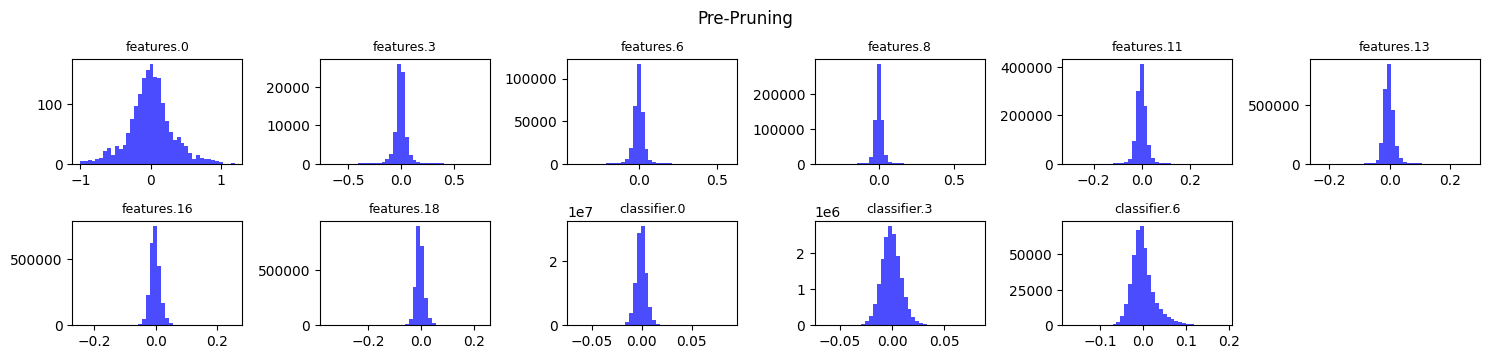

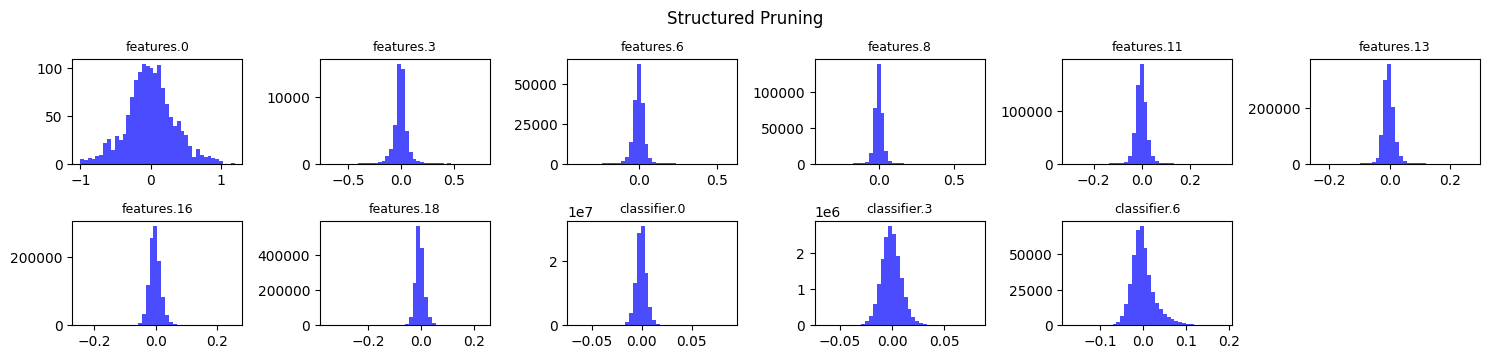

In [83]:
plot_weight_histograms(vgg11, "Pre-Pruning")
plot_weight_histograms(vgg_pruned, "Structured Pruning")

In [84]:

acc = evaluate(vgg_pruned, test_loader, device)
print(f"Post-Structured-Pruning no finetuning accuracy: {acc:.2f}%")

acc = evaluate(vgg_pruned, small_test_loader, device)
print(f"Post-Structured-Pruning no finetuning accuracy (small): {acc:.2f}%")

Post-Structured-Pruning no finetuning accuracy: 54.93%
Post-Structured-Pruning no finetuning accuracy (small): 54.60%
